In [ ]:
# 구글 드라이브 연결

from google.colab import drive
import shutil
import os

drive.mount('/content/drive')

project_path = '/content/drive/MyDrive/examples/2장/data'
os.makedirs(project_path, exist_ok=True)

# 현재 경로를 /content/drive로 설정
os.chdir(project_path)
print("현재 작업 디렉토리:", os.getcwd())
os.listdir(project_path)

Mounted at /content/drive
현재 작업 디렉토리: /content/drive/MyDrive/ch2


['shipsnet.7z',
 'dance.mov',
 'heart_rgb.png',
 'heart_gray.png',
 'heart.png',
 'sudoku.jpeg',
 'dog.png',
 'cat.png']

In [ ]:
!apt-get install p7zip-full
!7z x shipsnet.7z

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 29284571 bytes (28 MiB)

Extracting archive: shipsnet.7z
--
Path = shipsnet.7z
Type = 7z
Physical Size = 29284571
Headers Size = 72561
Method = LZMA2:24
Solid = +
Blocks = 1

  0%     10% 1       10% 14 - shipsnet/0__20160704_204237_0 . 0501979_37.895241180162884.png                                                                         10%

In [ ]:
import numpy as np
import json
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score


# 데이터셋 정보가 담긴 json 파일 로드
f = open(r'./shipsnet.json')
dataset = json.load(f)
f.close()

dataset.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

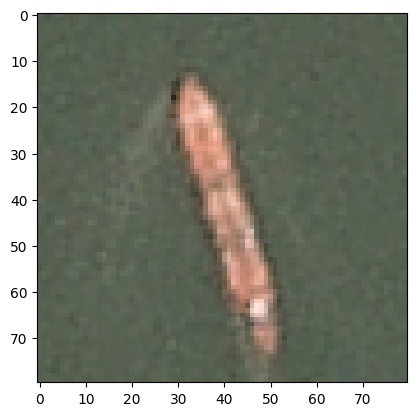

In [ ]:
data = np.array(dataset['data']).astype('uint8')
img_length = 80
data = data.reshape(-1,3,img_length,img_length).transpose([0,2,3,1])

# 샘플 이미지 시각화: 인공위성에서 촬영한 배 사진
plt.imshow(data[51])

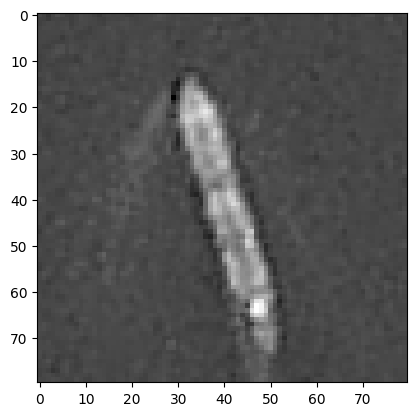

In [ ]:
# 이미지를 모두 그레이스케일로 변환
# : 신호등 색상과 같이 색상이 중요한 특징으로 작용하는 경우가 아니라면
#   그레이스케일로 변환하는 것이 객체의 고유한 특성을 더 정확히 분석할 수 있다.

data_gray = [ color.rgb2gray(i) for i in data]
plt.imshow(data_gray[51], cmap='gray')

In [ ]:
# hog descriptor 학습
# hog = 이미지를 그리드로 나눈 후, 각 그리드 내의 객체의 방향(그래디언트)을 데이터화 한 것

ppc = 16
hog_images = []
hog_features = []
for image in data_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

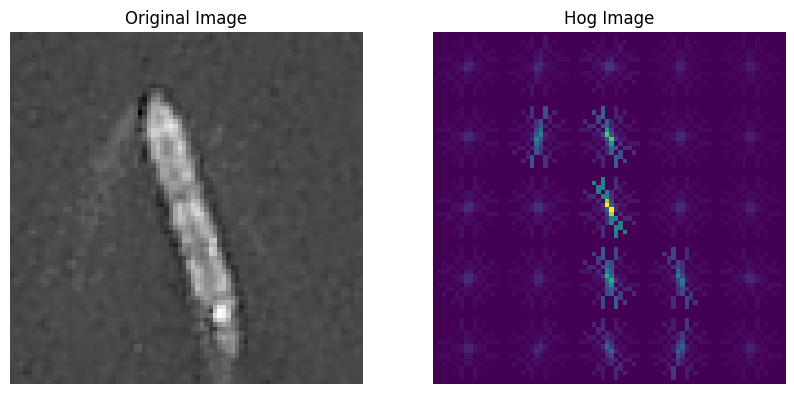

In [ ]:
# 이미지 시각화
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# 원본 이미지 시각화
axs[0].imshow(data_gray[51], cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

# 추출한 hog 정보 시각화
axs[1].imshow(hog_images[51])
axs[1].set_title('Hog Image')
axs[1].axis('off')

plt.show()

In [ ]:
# SVM Classifier 초기화
clf = svm.SVC()

labels =  np.array(dataset['labels']).reshape(len(dataset['labels']),1)
hog_features = np.array(hog_features)

# hog 특징과 레이블 정보를 하나의 데이터 프레임에 통합
data_frame = np.hstack((hog_features, labels))
np.random.shuffle(data_frame)

In [ ]:
percentage = 80
partition = int(len(hog_features)*percentage/100)

# 학습/테스트 데이터 분리 = 8 : 2
x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2240, 512), (560, 512), (2240,), (560,))

In [ ]:
# 모델 학습
clf.fit(x_train,y_train)

SVC()

In [ ]:
y_pred = clf.predict(x_test)

print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.9946428571428572


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       420
         1.0       0.99      0.99      0.99       140

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560

